## Imports

In [63]:
import numpy as np
import networkx as nx
from qibo import matrices, optimizers
from qibo.hamiltonians import Hamiltonian
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## MAXcut Hamiltonian

In [6]:
def maxcut(nqubits, norm=2, random_graph=False):
    """Builds maxcut hamiltonian"""
    if random_graph:
        aa = np.random.randint(1, nqubits*(nqubits-1)/2+1)
        graph = nx.random_graphs.dense_gnm_random_graph(nqubits, aa)
        V = nx.adjacency_matrix(graph)

    ham = np.zeros(shape=(2**nqubits,2**nqubits), dtype=np.complex128)
    for i in range(nqubits):
        for j in range(nqubits):
            h = np.eye(1)
            for k in range(nqubits):
                if (k == i) ^ (k == j):
                    h = np.kron(h, matrices.Z)
                else:
                    h = np.kron(h, matrices.I)            
            M = np.eye(2**nqubits) - h
            if random_graph:
                ham += V[i,j] * M
            else:
                ham += M
    matrix = - 1/norm * ham
    
    return Hamiltonian(nqubits, matrix, numpy=True)


def Qu(beta, r, eps=1e-3):
    return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)

## Cross-check results and plots

In [53]:
%%time
bstep = 5
K = 0.3
normE = 40
ntemp = 20
reali = 100
nmax = 9

Q = np.zeros(shape=(nmax-1, ntemp))
Qn = np.zeros(shape=(nmax-1, ntemp))
Qaa = np.zeros(shape=(nmax-1, ntemp))
Qeff = np.zeros(shape=(nmax-1, ntemp))

for n in range(2, nmax+1):

    print("n =",n)
    
    for _ in range(reali):
        H = maxcut(n, norm=normE, random_graph=True)
        energy = np.real(H.eigenvalues())
        lmin = np.min(energy)
        lmax = np.max(energy)

        for p in range(ntemp):
            bh = (p+1) * bstep
            r = np.int64(np.round(K * bh))            
            beta = bh/r*np.ones(r) * np.arange(1, r+1)
            Qbeta = np.ceil(Qu(np.hstack([beta[0], np.diff(beta)]), r))
                    
            Zbeta = np.sum(np.exp(-beta.reshape(-1,1)[:-1] * energy.reshape(1,-1)), axis=1)
            Psbeta = Zbeta / np.exp(-beta[:-1]*lmin) / 2**n
            Qr = np.sum(Psbeta * Qbeta[1:]) + Qbeta[0]
            Qeffr = 1 + np.sum(Psbeta)            
            Zbeta = np.sum(np.exp(-beta[r-1]*energy))
            Psbeta = Zbeta / np.exp(-beta[r-1]*lmin) / 2**n
            
            coeff = 1/Psbeta
            Quconst = Qu(bh, 1)
            Qeff[n-2, p] += Qeffr * Qu(bh/r, r)
            Q[n-2,p] += coeff * Qr
            Qn[n-2,p] += coeff * Quconst
            Qaa[n-2,p] += np.sqrt(1/Psbeta) * Quconst
            
Q /= reali
Qn /= reali
Qaa /= reali
Qeff /= reali

n = 2
[[16.46504866]] [[12.31950564]] [[11.04136564]] [[12.92658153]]
CPU times: user 5.48 ms, sys: 15 µs, total: 5.49 ms
Wall time: 4.45 ms


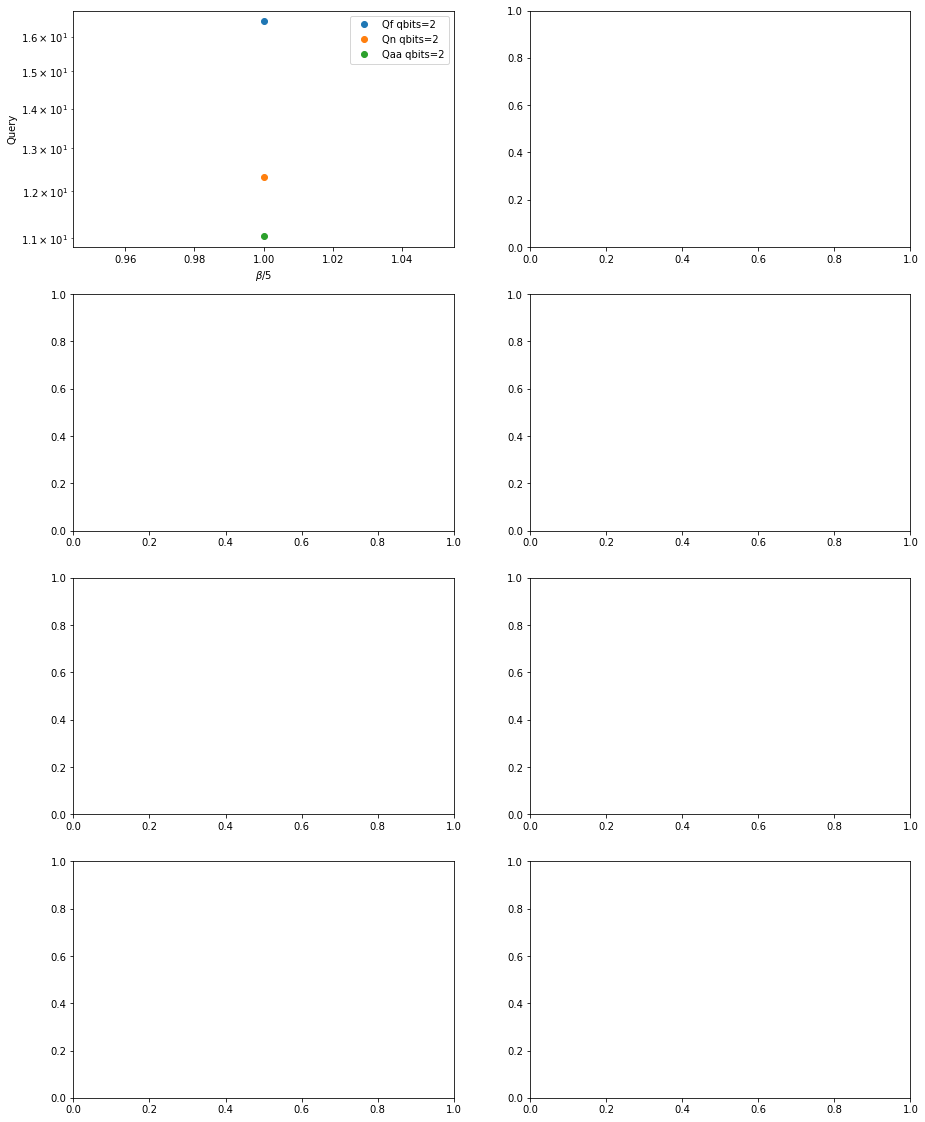

In [12]:
fig, axs = plt.subplots(4, 2, figsize=(15,20))
axs = axs.flatten()
for i in range(2,nmax+1):
    b = range(1,ntemp+1)
    axs[i-2].plot(b, Q[i-2], 'o', label='Qf qbits=%d' % i)
    axs[i-2].plot(b, Qn[i-2], 'o', label='Qn qbits=%d' % i)
    axs[i-2].plot(b, Qaa[i-2], 'o', label='Qaa qbits=%d' % i)
    axs[i-2].legend()
    axs[i-2].set_yscale('log')
    axs[i-2].set_ylabel('Query');
    axs[i-2].set_xlabel('$\\beta / 5$');

Text(0, 0.5, 'Query')

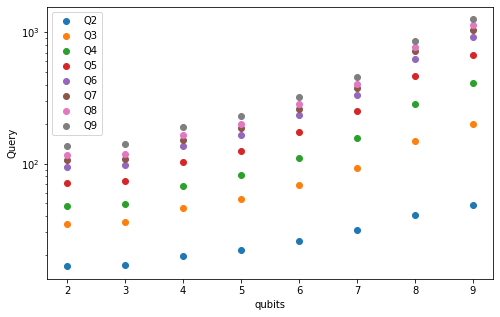

In [131]:
plt.figure(figsize=(8,5))
for i in range(2, nmax+1):
    plt.plot(range(2, nmax+1), Q[:,i-2], 'o', label='Q%s' % i)
plt.yscale('log')
plt.legend()
plt.xlabel('qubits')
plt.ylabel('Query')

## Optimization

         Current function value: 57.019557
         Iterations: 1
         Function evaluations: 68
         Gradient evaluations: 21
Value: 57.01955718217717
params [2.01]


<ipython-input-6-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)
<ipython-input-6-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


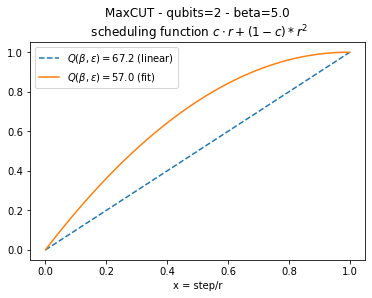

In [202]:
def FragmentedQuITE(hamiltonian, r, b, query, schedule, 
                    eps=1e-3, method='BFGS', options=None,
                   initial_parameters=None):
    """Test function for optimization."""
    n = hamiltonian.nqubits
    energy = np.real(H.eigenvalues())
    lmin = np.min(energy)
    lmax = np.max(energy)
    
    def loss(params):
        beta = np.array([ b*schedule(step/r, params) for step in range(1, r+1)])
        Qbeta = np.ceil(query(np.hstack([beta[0], np.diff(beta)]), r, eps))
        Zbeta = np.sum(np.exp(-beta.reshape(-1,1)[:-1] * energy.reshape(1,-1)), axis=1)
        Psbeta = Zbeta / np.exp(-beta[:-1]*lmin) / 2**n
        Qr = np.sum(Psbeta * Qbeta[1:]) + Qbeta[0]
        Zbeta = np.sum(np.exp(-beta[r-1]*energy))
        Psbeta = Zbeta / np.exp(-beta[r-1]*lmin) / 2**n    
        Q = 1/Psbeta * Qr
        return Q
    
    result, parameters = optimizers.optimize(loss, initial_parameters, 
                                            method, options=options)
    return result, parameters
    
#sc = lambda t, _: t
def spolynomial(t, params):
    #f = sum(p * t ** (i + 2) for i, p in enumerate(params))
    #f += (1 - np.sum(params)) * t
    #return f
    return params[0] * t + (1 - params[0]) * t**2
sc = spolynomial

nqubits = 2
r = 15
beta = 5

ref, _ = FragmentedQuITE(maxcut(nqubits, norm=40.0, random_graph=True), 
                r=r, b=beta, query=Qu, schedule=lambda t,_: t,
                initial_parameters=np.array([1]),
                method='BFGS', options={'disp': 0})

res, p = FragmentedQuITE(maxcut(nqubits, norm=40.0, random_graph=True), 
                r=r, b=beta, query=Qu, schedule=sc,
                initial_parameters=np.array([1]),
                method='BFGS', options={'disp': 1})
print('Value:',res)
print('params', p)

xx = np.linspace(0,1,50)
plt.title('MaxCUT - qubits=%d - beta=%.1f\n scheduling function $c \cdot r + (1-c) * r^2$' % (nqubits, beta))
plt.plot(xx, [i for i in xx], '--', label=r'$Q(\beta,\epsilon)=%.1f$ (linear)' % ref);
plt.plot(xx, [sc(i, p) for i in xx], label=r'$Q(\beta,\epsilon)=%.1f$ (fit)' % res);
plt.xlabel('x = step/r')
plt.legend()